Project Ideas


suggested project: analyze wind speed around the country with a view to a wind farm


## Project Plan

__Research wind farms in Ireland__

- where are they usually located?
- what wind conditions do they need? any other site considerations? Rural locations.
- how much electricity do they generate? summer vs winter?
- cost?
- lifespan? 
- advantages
- disadvantages
- anything else?

__Project questions__

What's the relationship between wind speed and power generated? Does the wind direction affect power generation? 

Is there a trend in wind speed? Is Ireland getting winder? Variations across the year? Time of day?

Is the technology in wind turbines improving? Is more electricity being generated for the same wind speed?

Does rain/temperature/anything affect the output? 

What happens during a storm? Does amount of wind generated electricity decrease/increase? 

Predict power output for wind farms in Ireland for the next week. Tricky

As I have weather information could solar power to fill the gaps when wind speeds are low? Probably too big a task for this project. 


__Find data__

Weather data from met Éireann historical data.
    can select by site, perhaps initially analyse data for a number of weather stations near a wind farm and also weather stations not near a wind farm. From the data can I see why that site was selected?



Is there much variation in wind across the country? Eirgrid data for entire country. 

## Introduction

Since the first commercial wind farm opened at Bellacorrick, Co Mayo in 1992 the capacity of wind farms in Ireland has increased significantly. There are now over 300 wind farms in the Republic of Ireland producing 4780 MW of energy each year with 568 MW in construction. In 2000, the [capacity was only 116.5 MW](https://cms.eirgrid.ie/sites/default/files/publications/Wind-Installed-Capacities-May-24.png). Ireland’s largest wind farm is the Galway Wind Park in Connemara. Each turbine in the wind park can generate 3 MW of electricity to give a total capacity of 192 MW. County Kerry wind farms, with a capacity of 746 MW, produced more wind energy that any other county (1664 GWh in 2023). Three counties in Ireland have no wind farms, Co. Kildare, Co. Longford and Co. Westmeath. https://www.windenergyireland.com/about-wind/wind-energy-by-county

Wind farms are located in windy sites far away from houses and trees. It is important that is is accessible by lorries during construction. https://www.teagasc.ie/rural-economy/rural-development/diversification/wind-energy/ Some considerations for site suitability are 
is the site windy? exposed and distant from trees and buildings? Is the site away from houses? Can lorries access the site for construction? Is the area a protected habitat? Is the area of landscape significant? Is there a high voltage grid connection nearby and if so, is there capacity on the line for new generation?  __MORE RESEARCH__

Increasing the amount of electricity produced from renewable sources is one of the aims of [Ireland’s Climate Action Plan](https://www.gov.ie/pdf/?file=https://assets.gov.ie/296414/7a06bae1-4c1c-4cdc-ac36-978e3119362e.pdf#page=null). It is hoped that by 2030, 80% of Ireland's electricity will be produced from renewable sources, of which 9000 MW should come from onshore wind energy. According to the [SEAI](https://www.seai.ie/data-and-insights/seai-statistics/renewables), currently ~ 40% of Ireland’s electricity is from renewable sources, with one third from wind energy. In contrast, in 2023, solar-PV generation accounted for 1.9% of electricity supply which is the equivalent of providing all the country's electricity needs for 1 full week. 

The amount of electricity a turbine generates depends on the type of turbine and the wind conditions at any time. According to the most recent information available for 2019 - 2022, from [Orsted, a wind energy company with a number of wind farms in Ireland](https://orsted.ie/renewable-energy-solutions/onshore-wind/onshore-wind-facts/is-onshore-wind-power-reliable?gad_source=1&gclid=Cj0KCQiAvbm7BhC5ARIsAFjwNHsqQo_o5BNQDDSs188yJNVjuNKutenLgB4fyrrApMoVsbYHk8igaZUaAk-YEALw_wcB), 91% of the time there is enough wind for production. 1% of time there is too much wind, 8% too little wind. Older turbines are less efficient than newer turbines. In Barnesmore, Co Donegal, there is a project with planning permission to repower an existing 15 MW wind farm with 25 turbines and replace it with 13 turbines capable of generating 60-70 MW. Fewer turbines producing more power. 

There are many advantages to wind energy. There are no carbon emissions and they are 100% efficient at turning wind into electricity. _GET MORE RECENT DATA_. Wind energy avoided 4.5 million tonnes of CO2 in 2020. There are some carbon emissions during production but it is estimated that after the 'carbon payback period' of 6- 18 months the turbine has already saved more than was created from its production. It is cheaper than fossil fuels so it should drive down the price of power. It is local and removes dependency on costly imported gas. 

Not everything is plain sailing when it comes to wind energy. It only works if there is wind and it is an intermittent source of electricity. Over the first ten months of 2024, 14 per cent of wind energy production was lost because of [challenges with the transmission network](https://www.windenergyireland.com/latest-news/7815-wind-farms-provided-32-per-cent-of-ireland-s-electricity-so-far-in-2024-3). When this happens wind farms are instructed to reduce the amount of power they produce or shut down completely, resulting in the use of more expensive fossil fuels. This is called ['dispatch down'](https://cms.eirgrid.ie/sites/default/files/publications/Wind-DD-Historical-December-2024.png). Dispatch down can arise due to constraints and curtailments. Ireland's electricity operates at a frequency of 50 Hz. Wind energy is 'non-synchronous', which means that the frequency at which the wind produces energy is not at 50 Hz. To ensure the frequency levels stay stable Eirgrid have the 'System Non-Synchronous Penetration (SNSP) limit in place. SNSP limit is the best known form of curtailment. The SNSP limit has been increasing steadily and it is currently 75%. This means that on a very windy day wind farms are dispatched down until they reach the 75% limit. 

The expected lifespan of a turbine is 30 years but in Ireland some turbines only have planning permission for 20-25 years. Wind energy companies are attempting to extend the planning permission so that the wind farms can operate beyond their current planning permission. This is not a straight forward task as some of the existing wind farms are in locations that, since they were built have been rezoned as unsuitable for wind energy by local county councils. Others are in or close to areas now designated as Special Protected Areas. It is estimated that up to 20% of current wind farms could be lost under the current planning restrictions, which would make the [Climate Action Plan unachievable](https://www.windenergyireland.com/latest-news/7733-dozens-of-wind-farms-at-risk-from-outdated-planning-decisions-2) by 2030. 


End of life or end of planning permission
extend by repair or maintenance
Repower replace old turbines with the latest larger and more efficient models
Decommission = dismantle the wind farm  https://www.derrybrienwindfarm.ie/info

85-95% of turbine is mostly made of steel and can be recycled, but the blades present a challenge. Blades are made of fibreglass or carbon fibre held together with resin and cannot be easily or efficiently broken down for recycling.


https://www.seai.ie/sites/default/files/data-and-insights/seai-statistics/key-publications/renewable-energy-in-ireland/First-Look-Renewable-Energy-in-Ireland-Report.pdf

https://www.greencollective.io/

https://www.greencollective.io/post/annual-recap-2023

https://www.seai.ie/data-and-insights/seai-statistics/renewables


Disadvantages - Only works if there is wind. Intermittent source of electricity. Life span and recycling of turbines.

https://windenergyireland.com/latest-news/2526-dispatch-down-and-the-fight-against-climate-change

https://windenergyireland.com/about-wind/the-basics/facts-stats



In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Modules for machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn.model_selection import TimeSeriesSplit

## The Data

About the data set. 

## Organising and Cleaning the Data


Would be convenient to have all the data in one large data set. Need to research working with large data sets. More difficult to load than smaller data sets.

## Wind Electricity Data

[Eirgrid's real-time system information](https://www.eirgrid.ie/grid/real-time-system-information) and [Eirgrid's smart grid dashboard](https://www.smartgriddashboard.com/#all) provide information on the status of the electricity grid. Both sites provide similar information and present it in different formats. Information on the current system demand, the total electricity production, the actual and forecast amount of electricity generated by wind energy, and the amount of imported electricity is available. THe electricity produced is measured in MW. Data is recorded every 15 minutes. The results can be filtered by all of Ireland, the Republic of Ireland, and Northern Ireland. One disadvantage of the site is that it is only possible to view information for a day at a time and download data for a single day, up to one month ago.

Despite extensive searching, there doesn't appear to be an official source of Eirgrid's historical data. However, I found a [GitHub repository by Daniel Parke](https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main), who has written a Python script to download the historical data from Eirgrid. His GitHub repository contains CSV files for the actual amount of electricity generated, actual demand, and amount of electricity produced by wind energy for every year from 2014 to early 2024. As the Met Éireann weather data is for the Republic of Ireland, the CSV files for the amount of wind energy produced in the Republic of Ireland from 2014 to 2023 were downloaded from this GitHub repository. To obtain the data for 2024 I ran his python script, eirgrid_downloader.py (https://github.com/Daniel-Parke/EirGrid_Data_Download/blob/main/eirgrid_downloader.py) on the 1st Jan 2025 to get the data for 2024. 

Each CSV file was downloaded to the electricity directory and each CSV file has one year's worth of data. The CSV files were merged and cleaned as outlined in [clean_electricity.ipynb](clean_electricity.ipynb) to give the CSV file, [hourly_electricity.csv](PFDA-project\data\electricity\clean_data\hourly_electricity.csv), which will be used for this analysis. 

In [ ]:
# Load the hourly_electricity data into pandas
hourly_electricity_df = pd.read_csv('data/electricity/clean_data/hourly_electricity.csv', index_col= 'date', parse_dates= ['date'])
hourly_electricity_df.head()

,wind_value
date,
2014-01-01 00:00:00,976.75
2014-01-01 01:00:00,914.25
2014-01-01 02:00:00,938.50
2014-01-01 03:00:00,911.25
2014-01-01 04:00:00,915.00


## Weather Data

The weather data was downloaded from historic met eireann sites. Data from a range of weather stations was downloaded. The selected weather stations were mostly based on their proximity to a wind farm. A number were selected for the size of the data set. To see if Ireland is getting windier. Oldest weather stations with data are Dublin airport and Valentia who have data from 1 Jan 1944. 

Met Eireann weather data is recorded hourly.

Weather Data

What I'm aiming to do

Look at wind speeds for the entire country. Is there much variability? Electricity generation values for the entire country. 

    Read all the csv files in weather directory into pandas.

        Problems: some csv files have a different numbers of rows to skip. Function to remove the unnecessary rows from csv file. 

        The dataframe would ideally be the location. This is proving very difficult. Have written a function to extract the location from file name. 

    Refine the dataframe to the years 2014 onwards. Write a function. 

    Merge the dataframes
        Can all the merging be done in one step? Write a function. 

Analyse the data. 


### Is there much variation in wind speed across the country? 

Electricity generated is given for ROI not broken down by wind farm.

Electricity data from 2014, so to compare wind speed and amount of electricity generated by wind only need weather data from 2014. 


Write a function to read in the weather data. Basic elements are the same skip rows, na_values, use columns, parse_dates

What columns are needed? 
date, rain, temp, msl, wdsp, wddir, 

sun, clht, clamt not recorded for all weather stations. so not of interest. 

Remove explanatory rows in csv file. 

# Load Data Sets

In [3]:
weather_df = pd.read_csv('data\weather\merged_data\weather_mean.csv', 
                              index_col= 'date', 
                              parse_dates= ['date']
                              )

weather_df.head()

,msl,rain,temp,wddir,wdsp
date,,,,,
2014-01-01 00:00:00,988.63,0.02,5.52,189.17,11.58
2014-01-01 01:00:00,988.32,0.01,5.03,186.67,10.17
2014-01-01 02:00:00,987.72,0.03,5.09,170.83,9.17
2014-01-01 03:00:00,986.86,0.15,5.11,165.00,9.33
2014-01-01 04:00:00,985.55,0.20,5.21,157.50,9.75


In [4]:
electricity_df = pd.read_csv('data\electricity\clean_data\hourly_electricity.csv', 
                             index_col= 'date',
                             parse_dates= ['date']
                             )
electricity_df.head()

,wind_value
date,
2014-01-01 00:00:00,976.75
2014-01-01 01:00:00,914.25
2014-01-01 02:00:00,938.50
2014-01-01 03:00:00,911.25
2014-01-01 04:00:00,915.00


In [5]:
electricity_weather = pd.concat([weather_df, hourly_electricity_df], axis = 1)
electricity_weather.head()

,msl,rain,temp,wddir,wdsp,wind_value
date,,,,,,
2014-01-01 00:00:00,988.63,0.02,5.52,189.17,11.58,976.75
2014-01-01 01:00:00,988.32,0.01,5.03,186.67,10.17,914.25
2014-01-01 02:00:00,987.72,0.03,5.09,170.83,9.17,938.50
2014-01-01 03:00:00,986.86,0.15,5.11,165.00,9.33,911.25
2014-01-01 04:00:00,985.55,0.20,5.21,157.50,9.75,915.00


In [6]:
electricity_weather.to_csv('data/electricity_weather.csv')

In [7]:
electricity_weather.describe()

,msl,rain,temp,wddir,wdsp,wind_value
count,95689.000000,95689.000000,95689.000000,95689.000000,95689.000000,87670.000000
mean,1012.890921,0.138622,10.361173,203.174946,8.843595,980.438909
std,12.577328,0.270817,4.471356,62.601163,4.081186,778.718332
min,952.680000,0.000000,-4.420000,15.830000,1.500000,-44.000000
25%,1005.420000,0.000000,7.180000,160.000000,5.670000,316.000000
50%,1014.320000,0.030000,10.410000,210.830000,8.080000,790.750000
75%,1021.700000,0.150000,13.650000,250.000000,11.250000,1510.750000
max,1048.030000,4.720000,27.440000,350.830000,30.830000,3814.250000


In [8]:
electricity_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95689 entries, 2014-01-01 00:00:00 to 2024-12-01 00:00:00
Freq: h
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   msl         95689 non-null  float64
 1   rain        95689 non-null  float64
 2   temp        95689 non-null  float64
 3   wddir       95689 non-null  float64
 4   wdsp        95689 non-null  float64
 5   wind_value  87670 non-null  float64
dtypes: float64(6)
memory usage: 5.1 MB


In [9]:
electricity_weather.isna().sum()

msl              0
rain             0
temp             0
wddir            0
wdsp             0
wind_value    8019
dtype: int64

In [10]:
# find the missing rows
nan_rows = electricity_weather[electricity_weather.isna().any(axis = 1)]
nan_rows

,msl,rain,temp,wddir,wdsp,wind_value
date,,,,,,
2024-01-01 22:00:00,981.68,0.05,10.02,227.50,13.67,NaN
2024-01-01 23:00:00,981.94,0.05,10.10,236.67,13.42,NaN
2024-01-02 00:00:00,982.19,0.02,10.08,235.83,13.67,NaN
2024-01-02 01:00:00,982.29,0.04,10.08,232.50,13.92,NaN
2024-01-02 02:00:00,982.08,0.02,10.00,229.17,13.75,NaN
...,...,...,...,...,...,...
2024-11-30 20:00:00,1020.59,0.08,11.22,210.83,6.42,NaN
2024-11-30 21:00:00,1020.63,0.00,11.20,210.00,5.83,NaN
2024-11-30 22:00:00,1020.68,0.00,11.20,210.83,5.92,NaN


There is no wind electricity data for most of 2024, only part of Jan 1. 
Will drop the rows for now. The plan is on the 1st Jan to get the data for wind electricity generation for 2024.

Also update weather data. Some weather data has weather information for Nov 2024, others only have data up to end of Oct 2024.

In [11]:
electricity_weather = electricity_weather.dropna()

In [12]:
electricity_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87670 entries, 2014-01-01 00:00:00 to 2024-01-01 21:00:00
Freq: h
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   msl         87670 non-null  float64
 1   rain        87670 non-null  float64
 2   temp        87670 non-null  float64
 3   wddir       87670 non-null  float64
 4   wdsp        87670 non-null  float64
 5   wind_value  87670 non-null  float64
dtypes: float64(6)
memory usage: 4.7 MB


Plot of electricity and windspeeds since 2014

In [13]:
# Resample weather_df to monthly
monthly_weather = weather_df.resample('ME').mean()
monthly_weather.head()

,msl,rain,temp,wddir,wdsp
date,,,,,
2014-01-31,993.884435,0.244140,5.875793,211.225417,10.867594
2014-02-28,988.311429,0.275074,5.749241,212.415804,13.037649
2014-03-31,1013.142648,0.122809,7.045726,202.654597,9.622581
2014-04-30,1012.485083,0.075319,9.921472,176.797472,8.629181
2014-05-31,1014.004167,0.135013,11.358602,200.795336,8.646425


In [14]:
monthly_weather.shape

(132, 5)

How does the mean of the weather compare with the individual weather data

In [15]:
electricity_weather_mean = electricity_weather.resample('ME').mean()
electricity_weather_mean

,msl,rain,temp,wddir,wdsp,wind_value
date,,,,,,
2014-01-31,993.884435,0.244140,5.875793,211.225417,10.867594,774.699933
2014-02-28,988.311429,0.275074,5.749241,212.415804,13.037649,925.433780
2014-03-31,1013.142648,0.122809,7.045726,202.654597,9.622581,647.850806
2014-04-30,1012.485083,0.075319,9.921472,176.797472,8.629181,493.911111
2014-05-31,1014.004167,0.135013,11.358602,200.795336,8.646425,461.017809
...,...,...,...,...,...,...
2023-09-30,1010.985681,0.190417,14.788222,192.358847,7.810264,1162.765972
2023-10-31,1003.735202,0.218387,11.432567,172.093548,7.319919,1097.030914
2023-11-30,1003.643917,0.162222,8.180111,216.517389,8.727778,1549.451042


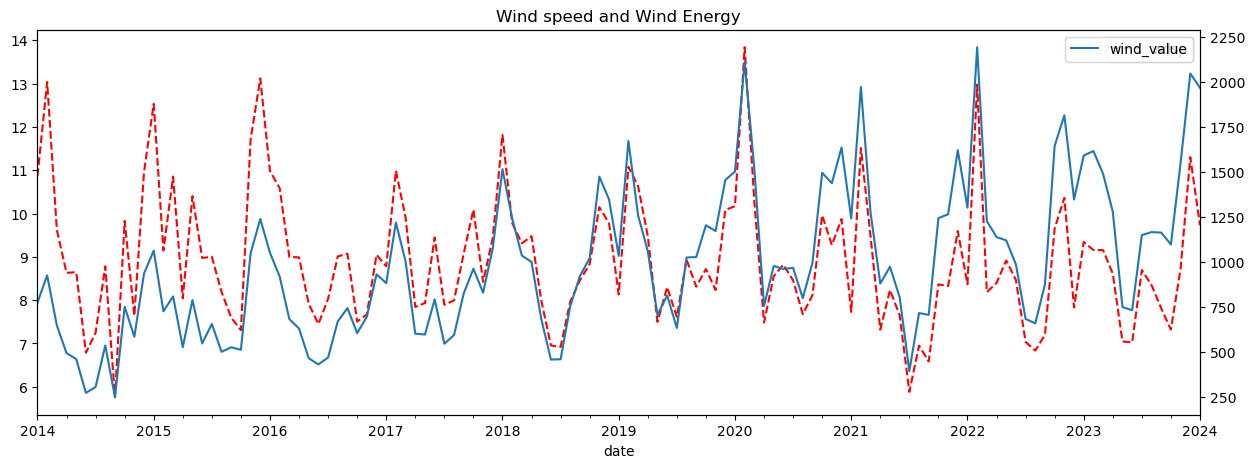

In [16]:
fig, ax = plt.subplots(figsize = (15,5))

electricity_weather_mean['wdsp'].plot(ax=ax, color = 'red', linestyle = 'dashed', legend= 'Wind Speed')

ax2 = ax.twinx()

electricity_weather_mean['wind_value'].plot(ax= ax2, legend= 'Wind energy')
plt.title('Wind speed and Wind Energy')
plt.show()

In [17]:
electricity_weather_yearly = electricity_weather.resample('YE').mean()
electricity_weather_yearly

,msl,rain,temp,wddir,wdsp,wind_value
date,,,,,,
2014-12-31,1009.612357,0.143957,10.373425,202.467838,8.969831,577.399201
2015-12-31,1014.334927,0.158261,9.749906,207.072672,9.750983,746.253796
2016-12-31,1014.133199,0.126036,10.061734,197.370263,8.765640,690.754696
2017-12-31,1014.494326,0.131568,10.331378,212.948322,8.970461,824.732820
2018-12-31,1012.622820,0.130381,10.145533,196.043534,8.948595,991.110859
2019-12-31,1011.955884,0.144884,10.228981,204.043289,8.903710,1083.981550
2020-12-31,1012.170619,0.155643,10.154603,203.890055,9.359723,1260.130009
2021-12-31,1014.549784,0.128242,10.373881,201.268314,8.113170,1085.230679
2022-12-31,1014.075034,0.129684,10.643288,202.243589,8.650444,1241.567837


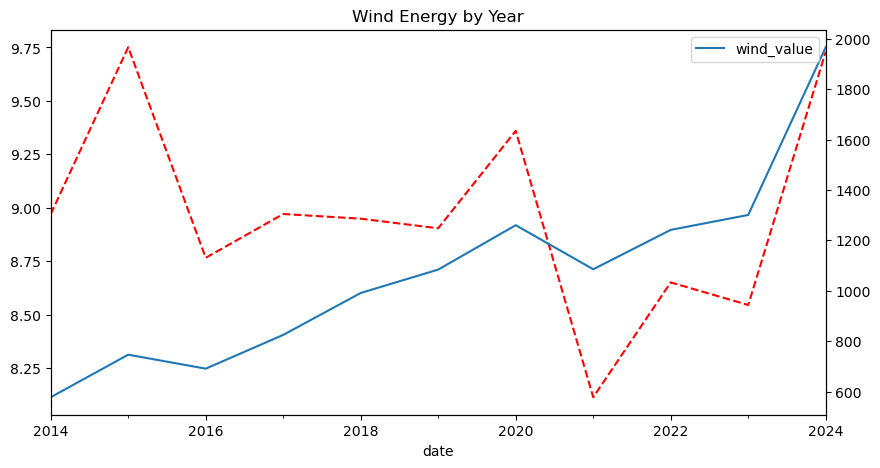

In [18]:
fig, ax = plt.subplots(figsize = (10,5))

electricity_weather_yearly['wdsp'].plot(ax=ax, color = 'red', linestyle = 'dashed')

ax2 = ax.twinx()

electricity_weather_yearly['wind_value'].plot(ax= ax2)
plt.title('Wind Energy by Year')
plt.legend()
plt.show()

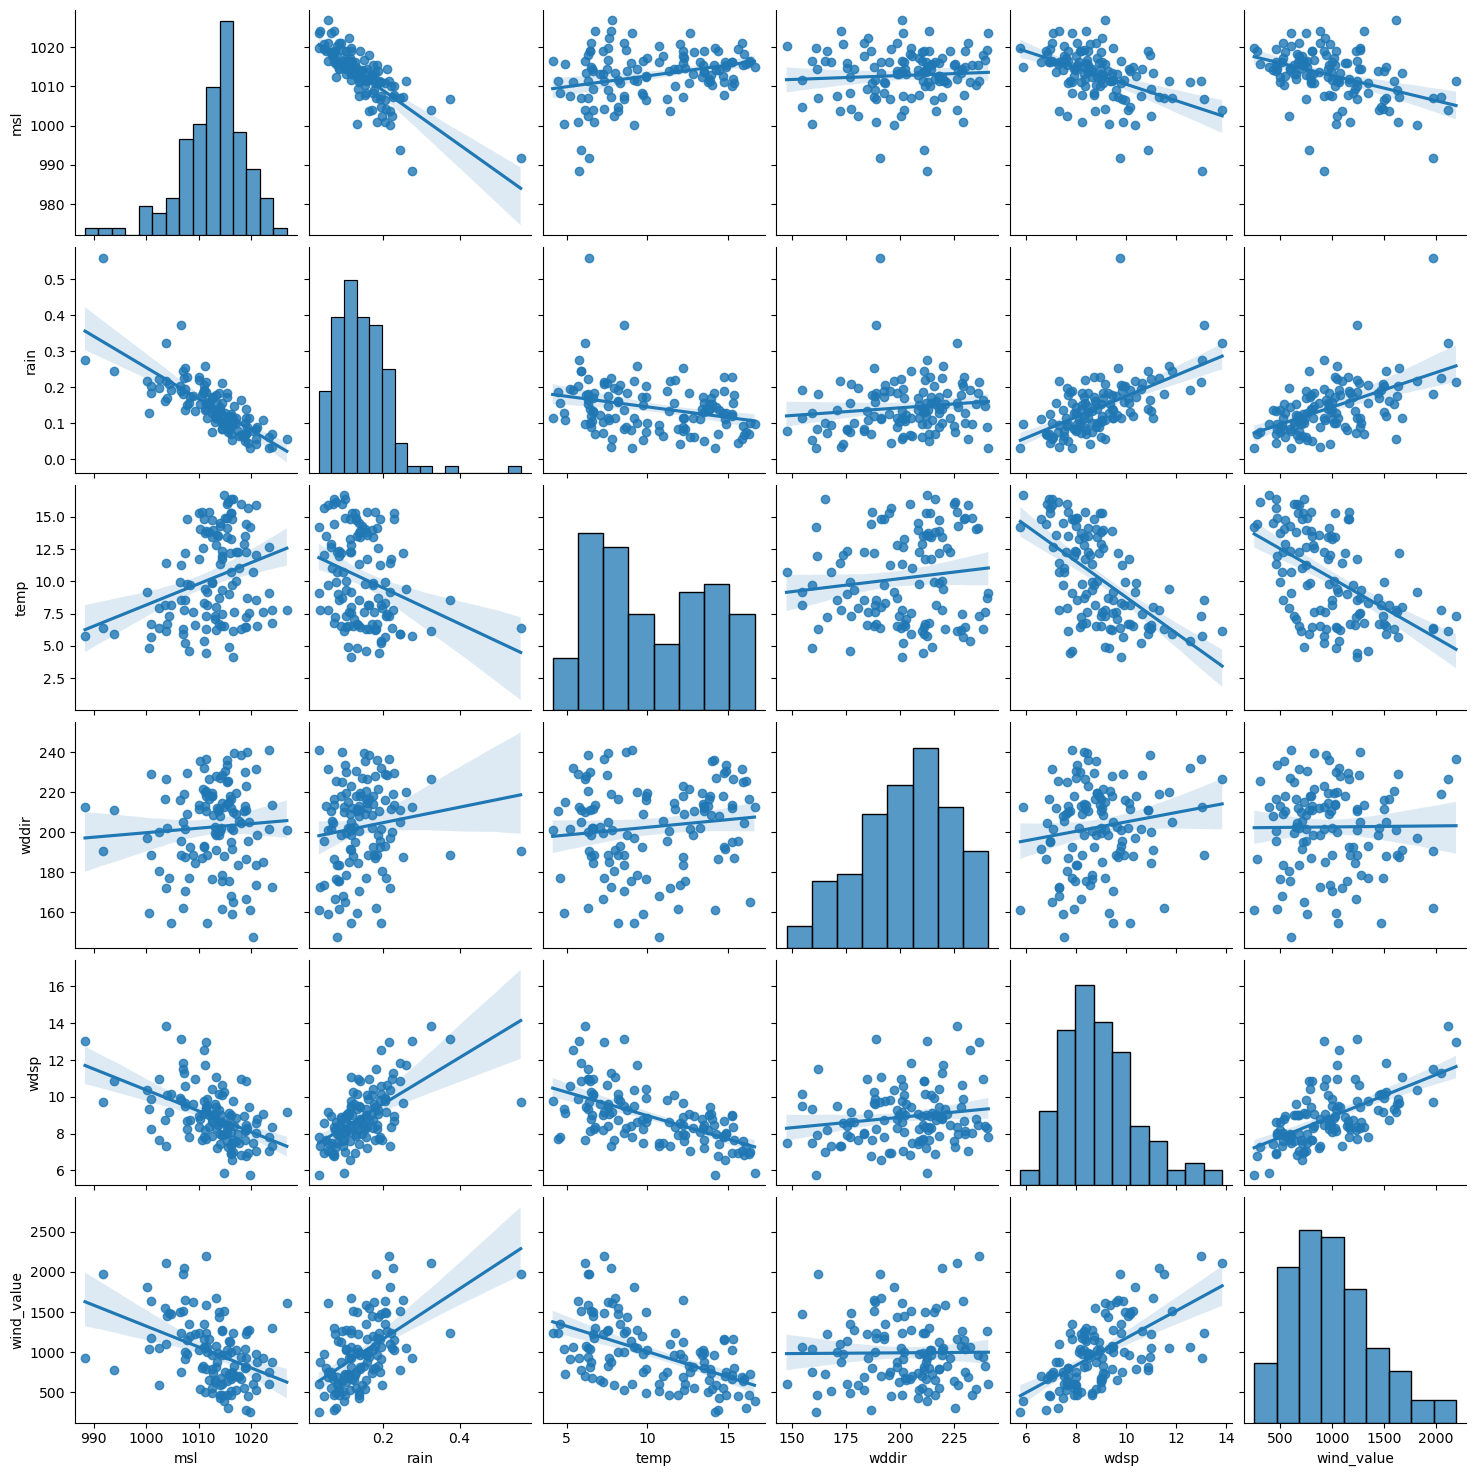

In [19]:
sns.pairplot(data= electricity_weather_mean, kind= 'reg')
plt.show()

<Axes: ylabel='date'>

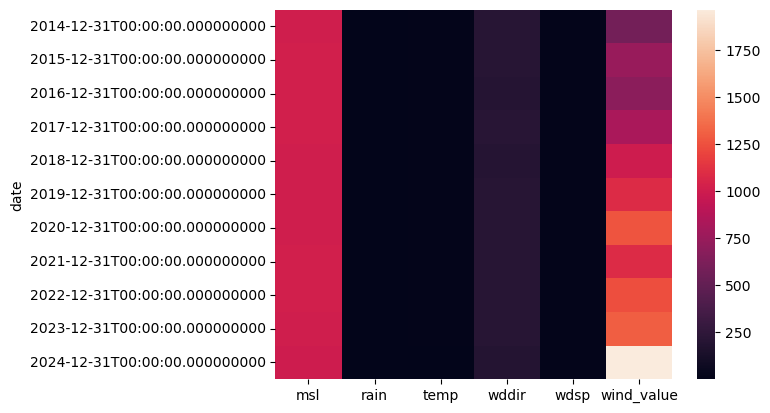

In [20]:
sns.heatmap(electricity_weather_yearly )

In [20]:
monthly_resample_summary = weather_df_mean.resample('ME').mean()
monthly_resample_summary.head()

NameError: name 'weather_df_mean' is not defined

In [ ]:

fig, ax = plt.subplots(figsize = (15,5))

monthly_resample_summary['wdsp'].plot(ax=ax, color = 'b', linestyle = 'dashed')

ax2 = ax.twinx()

monthly_weather['wdsp'].plot(ax= ax2)

plt.show()



Not ideal as I don't have the location names but if I had the location labelled in the data, I would have difficulty with the next step of merging the data based on mean

In [34]:
yearly_electricity = electricity_df.resample('YE').mean()

In [ ]:
yearly_electricity.plot()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
weather_df['wdsp'].plot()
plt.show()

In [ ]:
electricity_weather['wdsp'].boxplot()

plt.show()



### Is Ireland getting windier? Use Dublin Airport data. Recorded from 1944. Also Valentia recorded from then too. Do Dublin first.

In [ ]:
dublin_df = pd.read_csv('data/weather/hly532DublinAirport.csv', 
                        skiprows = 23, 
                        na_values = ' ',
                        index_col= 'date', 
                        parse_dates= ['date'], 
                        date_format = "%d-%b-%Y %H:%M")

dublin_df.head()

In [ ]:
dublin_df.info()

In [41]:
dublin_df = dublin_df.dropna()

In [ ]:
dublin_df.info()

In [43]:
dublin_monthly = dublin_df.resample('ME')

In [ ]:
dublin_yearly = dublin_df.resample('YE').mean()
dublin_yearly.head()

In [ ]:
dub

In [ ]:
#fig, ax = plt.subplots(figsize = (15, 5))

dublin_yearly['wdsp'].plot()

plt.show()

In [ ]:
dublin_yearly['wdsp'].mean()

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(dublin_monthly['wdsp'].mean(), model= 'additive', period = 12)
fig = decomposition.plot()


In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
#from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
valentia_df = pd.read_csv('data/weather/hly2275Valentia.csv', 
                        skiprows = 23, 
                        na_values = ' ',
                        index_col= 'date', 
                        parse_dates= ['date'], 
                        date_format = "%d-%b-%Y %H:%M")

valentia_df.head()

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

valentia_df['wdsp'].resample('YE').mean().plot()

plt.show()

In [57]:
valentia_monthly = valentia_df.resample('ME')

In [ ]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(valentia_monthly['wdsp'].mean(), model= 'additive', period = 12)
fig = decomposition.plot()


## Exploratory Data Analysis

In [ ]:
# Very quick plot of electricity generation by year

mean_wind_elect_year = electricity_df.resample('YE').mean()

mean_wind_elect_year.plot()
plt.show()

## Discussion of the Analysis

nice plots

## Machine Learning

some predictive analysis.

train
https://stackoverflow.com/questions/74025273/is-train-test-splitshuffle-false-appropriate-for-time-series

sklearn.model_selection.TimeSeriesSplit

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn.model_selection import TimeSeriesSplit


In [42]:
X = electricity_weather.drop('wind_value', axis= 1)

In [43]:
y = electricity_weather['wind_value']

In [44]:
print(X.shape, y.shape)

(87670, 5) (87670,)


https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split

https://medium.com/@Stan_DS/timeseries-split-with-sklearn-tips-8162c83612b9

In [45]:
tss = TimeSeriesSplit()

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [46]:
reg = LinearRegression()

reg.fit(X_train, y_train)

y_predictions = reg.predict(X_test)

r_squared = reg.score(X_test, y_test)

print(f'R squared: {r_squared}')

# Root Mean squared error, measured in units of target variable squared. 
rmse = root_mean_squared_error(y_test, y_predictions)

print(f'RMSE: {rmse}')

R squared: 0.5106049717993555
RMSE: 632.3661231754146


In [54]:
print("Predictions: {},\nActual Values: {}".format(y_predictions[:5], y_test[:5]))

Predictions: [11.49280711 54.14844155 21.19775615 72.92841197 25.33655463],
Actual Values: date
2022-05-03 03:00:00     73.50
2022-05-03 04:00:00    103.50
2022-05-03 05:00:00    110.50
2022-05-03 06:00:00     88.75
2022-05-03 07:00:00     57.00
Freq: h, Name: wind_value, dtype: float64


In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg = LinearRegression()

reg.fit(X_train_scaled, y_train)

y_predictions = reg.predict(X_test_scaled)


r_squared = reg.score(X_test_scaled, y_test)

print(f'R squared: {r_squared}')

# Root Mean squared error, measured in units of target variable squared. 
rmse = root_mean_squared_error(y_test, y_predictions)

print(f'RMSE: {rmse}')

R squared: 0.5106049717993558
RMSE: 632.3661231754145


In [75]:
X_test, X_test_scaled

(                         msl  rain   temp   wddir   wdsp
 date                                                    
 2023-07-03 07:00:00  1008.52  0.12  12.08  264.17   7.67
 2023-07-03 08:00:00  1008.74  0.27  12.63  275.83   8.58
 2023-07-03 09:00:00  1009.00  0.24  13.03  273.33  10.67
 2023-07-03 10:00:00  1009.21  0.14  14.16  275.83  11.50
 2023-07-03 11:00:00  1009.50  0.52  13.91  278.33  12.42
 ...                      ...   ...    ...     ...    ...
 2024-01-01 17:00:00   982.19  1.98   8.09  139.17  12.50
 2024-01-01 18:00:00   981.09  1.67   8.54  151.67  11.17
 2024-01-01 19:00:00   980.62  0.71   8.95  170.00  12.00
 2024-01-01 20:00:00   980.72  0.18   9.42  191.67  11.42
 2024-01-01 21:00:00   981.26  0.11   9.99  220.83  13.00
 
 [4383 rows x 5 columns],
 array([[ 0.7003181 , -0.51442666, -0.14907307,  0.26015519, -1.50838726],
        [ 0.69793121, -0.51442666, -0.20284624, -0.55376058, -1.50838726],
        [ 0.68997492, -0.51442666, -0.27902491,  0.36677752, -1.5083

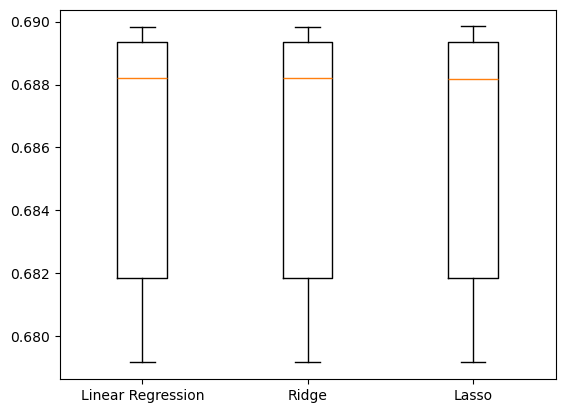

In [38]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 241)

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=241, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, tick_labels=models.keys())
plt.show()

In [39]:
for name, model in models.items():
    model.fit(X_train, y_train)
    model.predict(X_test)
    test_score = model.score(X_test, y_test)
    print(f'Test set accuracy: {test_score}')

Test set accuracy: 0.5106049717993555
Test set accuracy: 0.5106049172234967
Test set accuracy: 0.5105632942133947


In [40]:
for name, model in models.items():
  
    # Fit the model to the training data
    model.fit(X_train, y_train)
  
    # Make predictions on the test set
    y_predictions = model.predict(X_test).round(3)
  
    # Calculate the test_rmse
    test_rmse = root_mean_squared_error(y_test, y_predictions).round(3)
    print("{} Test Set RMSE: {}".format(name, test_rmse))

    test_r2 = model.score(X_test, y_test)
    print("{} R_squared:{}".format(name, test_r2))

Linear Regression Test Set RMSE: 632.366
Linear Regression R_squared:0.5106049717993555
Ridge Test Set RMSE: 632.366
Ridge R_squared:0.5106049172234967
Lasso Test Set RMSE: 632.393
Lasso R_squared:0.5105632942133947


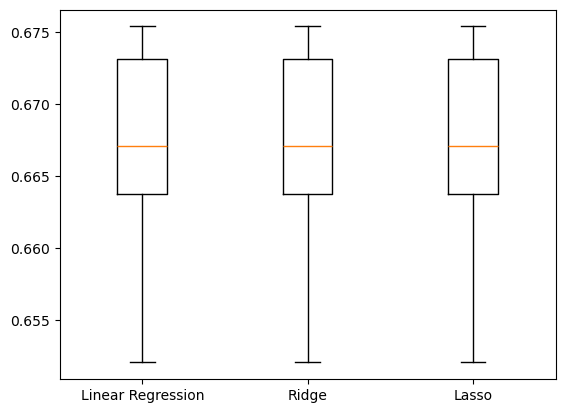

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.001), "Lasso": Lasso(alpha=0.001)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=241, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, tick_labels=models.keys())
plt.show()

In [100]:
results

[array([0.6745455 , 0.66891735, 0.65204642, 0.67536998, 0.66323568,
        0.66517288]),
 array([0.67454549, 0.66891735, 0.65204642, 0.67536998, 0.66323568,
        0.66517288]),
 array([0.67454547, 0.66891735, 0.65204649, 0.67536995, 0.66323567,
        0.66517289])]

In [99]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print(f'Test set accuracy {model}: {test_score}')

Test set accuracy LinearRegression(): 0.6607202338722675
Test set accuracy Ridge(alpha=0.001): 0.660720234125322
Test set accuracy Lasso(alpha=0.001): 0.6607202641669815


In [101]:
for name, model in models.items():
  
    # Fit the model to the training data
    model.fit(X_train_scaled, y_train)
  
    # Make predictions on the test set
    y_predictions = model.predict(X_test_scaled)
  
    # Calculate the test_rmse
    test_rmse = root_mean_squared_error(y_test, y_predictions)
    print("{} Test Set RMSE: {}".format(name, test_rmse))

    test_r2 = model.score(X_test_scaled, y_test)
    print("{} R_squared:{}".format(name, test_r2))

Linear Regression Test Set RMSE: 456.6178796487374
Linear Regression R_squared:0.6607202338722675
Ridge Test Set RMSE: 456.61787947845136
Ridge R_squared:0.660720234125322
Lasso Test Set RMSE: 456.61785926274655
Lasso R_squared:0.6607202641669815


In [109]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 241)

reg = LinearRegression()

reg.fit(X_train, y_train)
y_predictions = reg.predict(X_test)

# Calculate R-squared, default metric for linear regression, value between 0 and 1
r_squared = reg.score(X_test, y_test)

print(f'R squared: {r_squared}')

# Root Mean squared error, measured in units of target variable squared. 
rmse = root_mean_squared_error(y_test, y_predictions)

print(f'RMSE: {rmse}')

R squared: 0.6607202338722675
RMSE: 456.6178796487374


In [103]:
print("Predictions: {},\nActual Values: {}".format(y_predictions[:5], y_test[:5]))

Predictions: [ 843.07861213  846.22467218 1051.23409171 3029.58091683 1511.76482238],
Actual Values: [1104.75 1122.75 1321.75 2688.5  1615.5 ]


In [106]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
r2_score(y_test, y_predictions)

0.6607202338722675

Cross-validation
dependent on way the data is split.


In [110]:
kf = KFold(n_splits= 6, shuffle= True, random_state= 241)
reg = LinearRegression()
cv_results = cross_val_score(reg, X, y, cv = kf)
print(cv_results)
print(f'The mean score is {np.mean(cv_results).round(3)}, with standard deviation of {np.std(cv_results).round(3)}, {np.quantile(cv_results, [0.025, 0.975])}')


[0.65975244 0.66081688 0.66820821 0.66859111 0.66394387 0.66762369]
The mean score is 0.665, with standard deviation of 0.004, [0.6598855  0.66854325]


In [111]:
from sklearn.linear_model import Ridge
ridge_scores = []
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0]:
    ridge = Ridge(alpha= alpha)
    ridge.fit(X_train, y_train)
    y_predictions = ridge.predict(X_test)
    ridge_scores.append(ridge.score(X_test, y_test))

print(ridge_scores)

[0.6607202269272869, 0.6607201643857343, 0.6607195353597131, 0.6607129085355871, 0.6606295034967911]


In [112]:
from sklearn.linear_model import Lasso

lasso_scores = []
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0]:
    lasso = Lasso(alpha= alpha)
    lasso.fit(X_train, y_train)
    y_predictions = lasso.predict(X_test)
    lasso_scores.append(lasso.score(X_test, y_test))

print(lasso_scores)

[0.660715110943545, 0.6606432488563578, 0.6596212597015094, 0.6583002958188997, 0.5449273601817554]


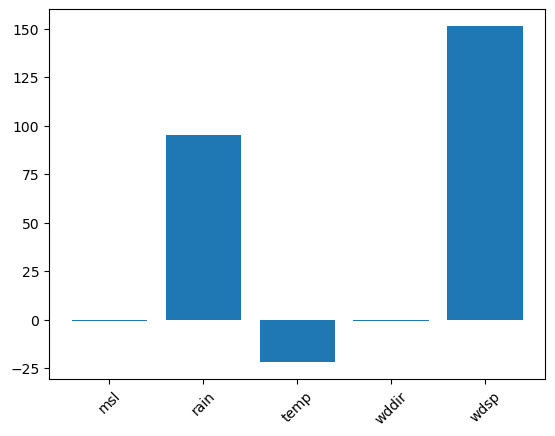

In [113]:
# Can be used to assess feature importance. 

names = electricity_weather.drop('wind_value', axis= 1).columns

lasso = Lasso(alpha= 0.1)
lasso_coef = lasso.fit(X, y).coef_
plt.bar(names, lasso_coef)
plt.xticks(rotation = 45)
plt.show()

In [114]:
# Hyperparameter tuning

from sklearn.model_selection import GridSearchCV

kf = KFold(n_splits= 5, shuffle= True, random_state = 241)

param_grid = {'alpha': np.arange(0.0001, 1, 10),
              'solver': ['sag', 'lsqr']}

ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv = kf)
ridge_cv.fit(X_train, y_train)

print(ridge_cv.best_params_, ridge_cv.best_score_)


{'alpha': 0.0001, 'solver': 'lsqr'} 0.6665646453114451


In [115]:
from sklearn.model_selection import RandomizedSearchCV

kf = KFold(n_splits= 5, shuffle= True, random_state = 241)

param_grid = {'alpha': np.arange(0.0001, 1, 10),
              'solver': ['sag', 'lsqr']}

ridge = Ridge()
ridge_cv = RandomizedSearchCV(ridge, param_grid, cv = kf, n_iter= 2)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_, ridge_cv.best_score_)


{'solver': 'lsqr', 'alpha': 0.0001} 0.6665646453114451


In [116]:
test_score = ridge_cv.score(X_test, y_test)
test_score

0.6607202402677993

In [117]:
# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.00001, 1, 20)}

# Instantiate lasso_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)

# Fit to the training data
lasso_cv.fit(X_train, y_train)
print("Tuned lasso parameters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

Tuned lasso parameters: {'alpha': 1e-05}
Tuned lasso score: 0.6665646395178532


In [118]:
electricity_weather.describe()

,msl,rain,temp,wddir,wdsp,wind_value
count,87670.000000,87670.000000,87670.000000,87670.000000,87670.000000,87670.000000
mean,1012.964527,0.140584,10.307719,202.747045,8.898029,980.438909
std,12.609695,0.274124,4.510656,62.543395,4.111215,778.718332
min,952.680000,0.000000,-4.420000,15.830000,1.500000,-44.000000
25%,1005.410000,0.000000,7.070000,159.170000,5.750000,316.000000
50%,1014.380000,0.030000,10.300000,210.000000,8.170000,790.750000
75%,1021.740000,0.150000,13.640000,250.000000,11.330000,1510.750000
max,1048.030000,4.720000,27.440000,350.830000,30.830000,3814.250000


In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(np.mean(X), np.std(X))
print(np.mean(X_train_scaled), np.std(X_train_scaled))

247.01158063191514 391.5158471325121
-1.1369746072280653e-14 1.0000000000000235


In [124]:
reg_scaled = LinearRegression()
reg_scaled.fit(X_train_scaled, y_train)
y_pred = reg_scaled.predict(X_test_scaled)

squared = reg_scaled.score(X_test_scaled, y_test)
squared



0.6607202338722675

In [125]:
from sklearn.pipeline import Pipeline

steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.001))]

pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

0.6607202641669815


Since 2011, electricity generated has been greater than windspeed. Improve model by excluding data before 2021. Could refine this further from the exact date in 2020 where this change occurred. 

In [55]:
data_2021_onwards = electricity_weather.loc['2021' : ]
data_2021_onwards

,msl,rain,temp,wddir,wdsp,wind_value
date,,,,,,
2021-01-01 00:00:00,1015.42,0.08,4.20,283.33,11.00,2087.25
2021-01-01 01:00:00,1015.71,0.06,3.83,225.83,10.33,2100.25
2021-01-01 02:00:00,1016.01,0.10,3.58,249.17,10.17,2136.50
2021-01-01 03:00:00,1016.48,0.08,3.41,250.83,9.75,2056.50
2021-01-01 04:00:00,1016.70,0.05,3.40,249.17,9.08,2037.50
...,...,...,...,...,...,...
2024-01-01 17:00:00,982.19,1.98,8.09,139.17,12.50,2883.00
2024-01-01 18:00:00,981.09,1.67,8.54,151.67,11.17,2954.25
2024-01-01 19:00:00,980.62,0.71,8.95,170.00,12.00,2857.75


In [56]:
X = data_2021_onwards.drop('wind_value', axis= 1)
y = data_2021_onwards['wind_value']

In [57]:
tss = TimeSeriesSplit()

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [58]:


reg = LinearRegression()

reg.fit(X_train, y_train)
y_predictions = reg.predict(X_test)

# Calculate R-squared, default metric for linear regression, value between 0 and 1
r_squared = reg.score(X_test, y_test)

print(f'R squared: {r_squared}')

# Root Mean squared error, measured in units of target variable squared. 
rmse = root_mean_squared_error(y_test, y_predictions)

print(f'RMSE: {rmse}')

R squared: 0.8088210039388066
RMSE: 402.74920983011447


In [59]:
print("Predictions: {},\nActual Values: {}".format(y_predictions[:5], y_test[:5]))

Predictions: [ 931.94486536 1109.42465306 1519.10434018 1632.6422316  1880.23696573],
Actual Values: date
2023-07-03 07:00:00    1783.25
2023-07-03 08:00:00    1722.75
2023-07-03 09:00:00    1867.00
2023-07-03 10:00:00    1837.75
2023-07-03 11:00:00    1781.00
Freq: h, Name: wind_value, dtype: float64


In [72]:
y_predictions

array([ 931.94486536, 1109.42465306, 1519.10434018, ..., 2149.8848987 ,
       1920.81387712, 2186.89852417])

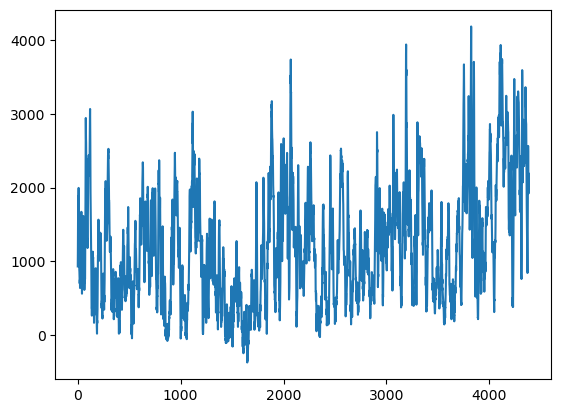

In [74]:
plt.plot(y_predictions)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

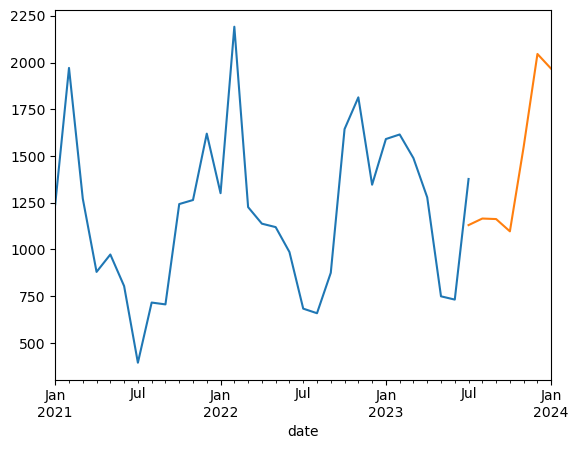

In [71]:
y_train.resample('ME').mean().plot(label = 'train')
y_test.resample('ME').mean().plot(label = 'test')
y_predictions.values.plot(label = 'predictions')
plt.legend()
plt.show()

In [67]:
kf = KFold(n_splits= 6)
reg = LinearRegression()
cv_results = cross_val_score(reg, X, y, cv = kf)
print(cv_results)
print(f'The mean score is {np.mean(cv_results).round(3)}, with standard deviation of {np.std(cv_results).round(3)}, {np.quantile(cv_results, [0.025, 0.975])}')

[0.79514029 0.80106266 0.81468807 0.84764228 0.81389919 0.808821  ]
The mean score is 0.814, with standard deviation of 0.017, [0.79588058 0.843523  ]


C:\Users\Martin\AppData\Local\Temp\ipykernel_25772\4060341310.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


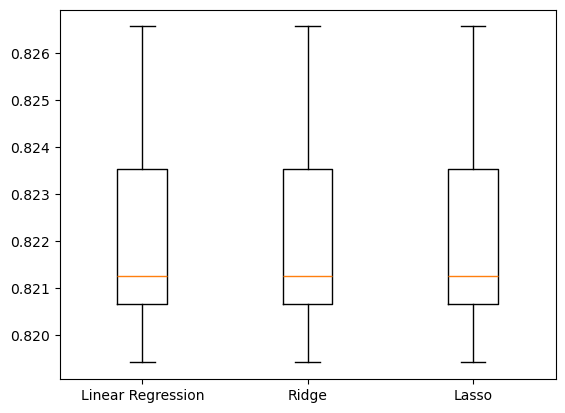

In [130]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.001), "Lasso": Lasso(alpha=0.001)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

In [131]:
for name, model in models.items():
  
    # Fit the model to the training data
    model.fit(X_train_scaled, y_train)
  
    # Make predictions on the test set
    y_predictions = model.predict(X_test_scaled)
  
    # Calculate the test_rmse
    test_rmse = root_mean_squared_error(y_test, y_predictions)
    print("{} Test Set RMSE: {}".format(name, test_rmse))

    test_r2 = model.score(X_test_scaled, y_test)
    print("{} R_squared:{}".format(name, test_r2))

Linear Regression Test Set RMSE: 373.14140785477883
Linear Regression R_squared:0.8295474571036406
Ridge Test Set RMSE: 373.1414094703343
Ridge R_squared:0.8295474556276557
Lasso Test Set RMSE: 373.1414389950096
Lasso R_squared:0.8295474286536663


Decision tree regression

In [154]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth = 2)
regr_2 = DecisionTreeRegressor(max_depth = 10)

regr_1.fit(X_train_scaled, y_train)
regr_2.fit(X_train, y_train)

y_1 = regr_1.predict(X_test_scaled)
y_2 = regr_2.predict(X_test_scaled)


r_squared = regr_1.score(X_test_scaled, y_test)
r_squared

0.7782922062192353

In [155]:
r_squared = regr_2.score(X_test_scaled, y_test)
r_squared

-1.5815543096589004

Elastic Net regression https://www.youtube.com/watch?v=1dKRdX9bfIo

In [157]:
from sklearn import linear_model

ENreg = linear_model.ElasticNet(alpha = 0.1, random_state = 241)
ENreg.fit(X_train_scaled, y_train)
y_pred = ENreg.predict(X_test_scaled)

r_2 = ENreg.score(X_test_scaled, y_test)
r_2



0.8261107259699264

https://realpython.com/linear-regression-in-python/

https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

## Conclusion



## References


http://www.iwea.ie/technicalfaqs


### Data Sets

[GitHub Daniel Parke]https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main


__Problems that arose__

[Git LFS (large file storage)](https://git-lfs.com/). Some of the weather data filew were larger than GitHub's recommended maximum file size of 50.00 MB. Installed and used Git lfs
